In [1]:
import pandas as pd
import numpy as np
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
from model import *
from data_preprocessing import *
from preprocess_text import Preprocess
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn import preprocessing

C:\Users\Amey\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [5]:
def perf_measure(y_actual, y_hat):
    wc = []
    y_act = []
    y_pre = []
    

    for i in range(len(y_hat)): 
        if not y_actual[i] == y_hat[i]:
            wc.append(i)
            y_act.append(y_actual[i])
            y_pre.append(y_hat[i])
        
    return wc,y_act,y_pre

def label_convert(label, label_mapping):
    for key in label_mapping:
        if label_mapping[key] == label:
            return key
    

def generate_pairwise_heatmap(dataframe, col1, col2, label_names = [], color = "Reds", annot = True):
    tuple_list = []
    num_labels = len(np.unique(dataframe[col1]))
    
    print('Number of Labels: \t {} \n Number of records: {}'.format(num_labels, (dataframe[col1].shape[0])))
    for index, row in mistakes.iterrows():
        class_tuple = (row[col1],row[col2])
        tuple_list.append(class_tuple)
        
    class_pairs = pd.Series(tuple_list).value_counts().keys().tolist()
    count_pairs = [x for x in pd.Series(tuple_list).value_counts()]
    pairwise_results = np.zeros([num_labels, num_labels],int).tolist()

    for pair,val in zip(class_pairs,count_pairs):

        i = pair[0]
        j = pair[1]

        pairwise_results[i][j] = val

    if label_names:
        hm = sn.heatmap(data = np.asarray(pairwise_results),xticklabels=label_names, 
                        yticklabels=label_names, cmap=color, annot = annot)
    else:
        hm = sn.heatmap(data = np.asarray(pairwise_results), cmap=color, annot = annot)
    
    return pairwise_results

def get_vocab(document):
    vocab = set()
    for text in document:
        for token in text.split():
            vocab.add(token)
    return vocab



<h3>Preparing data for training<h3>

In [4]:
pp = Preprocess([])

print('Loading Data\n\n')
x_train = pd.read_csv('../Data/training_data_marathi.csv')['text'].apply(lambda x : pp.clean_text(x))
y_train = pd.read_csv('../Data/training_data_marathi.csv')['label']
x_val = pd.read_csv('../Data/test_data_marathi.csv')['text'].apply(lambda x : pp.clean_text(x))
y_val = pd.read_csv('../Data/test_data_marathi.csv')['label']


print('Encoding Labels\n\n')
y_train, y_val, label_mappings = label_encoder(y_train, y_val)
y_train = y_train.reshape(y_train.shape[0], -1)
y_val = y_val.reshape(y_val.shape[0], -1)
print(label_mappings)
 

print('Building Vocab\n\n')
pad_len=100
padding_type='post'
truncating_type='post'

corpus = []

for text in x_train:
    corpus.append(text)

for text in x_val:
    corpus.append(text)
    

print('Tokenizing Train and Test\n\n')
tokenizer, x_train_tokenzied, x_val_tokenzied = tokenize_text(corpus,x_train, x_val)

print('Padding Train and Test\n\n')
x_train_padded, x_val_padded = pad_text(x_train_tokenzied, 
                                        x_val_tokenzied, 
                                        pad_len, 
                                        padding_type, 
                                        truncating_type)

Loading Data


Encoding Labels


{'bioche': 0, 'com_tech': 1, 'cse': 2, 'phy': 3}
Building Vocab


Tokenizing Train and Test


Padding Train and Test




<h3>Predicting results<h3>

In [6]:
model = model_load('../models/FINALS/LSTM_combined_embeddings.h5.h5')

In [7]:
results = np.argmax(model.predict(x_val_padded),axis = -1)
del(model)

In [8]:
wc, yact, yhat = perf_measure(y_val,results)

In [24]:
mistakes = pd.DataFrame(columns=['text','actual label','predicted label'])
mistakes['text'] = x_val.loc[wc]
mistakes['actual label'] = yact
mistakes['predicted label'] = yhat
mistakes['actual label'] = mistakes['actual label'].apply(lambda x : x[0])

<h3>Classification Analysis<h3>

In [10]:
print('Total classifaction mistakes: ',mistakes.shape[0])

Total classifaction mistakes:  387


Number of Labels: 	 4 
 Number of records: 387


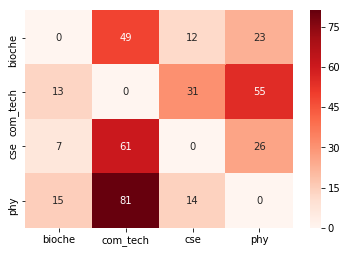

In [26]:
heatmap = generate_pairwise_heatmap(mistakes, 'actual label', 'predicted label',
                                    label_names= label_mappings.keys())

In [27]:
mistakes['word count'] = mistakes['text'].apply(lambda x : len(x.split()))
print('Word count stats:\n\n',mistakes['word count'].describe(),'\n\n')

mistakes['word count'].iplot(kind = 'hist', xTitle = "word count", yTitle = 'num records', 
                            title = "Histogram depicting distibution of word count across misclassified data" ,bins=(100))

Word count stats:

 count    387.000000
mean      16.449612
std       11.897421
min        2.000000
25%        8.000000
50%       13.000000
75%       20.000000
max       73.000000
Name: word count, dtype: float64 




In [29]:
mistakes['actual label'] = mistakes['actual label'].apply(lambda x: label_convert(x,label_mappings))
mistakes['predicted label'] = mistakes['predicted label'].apply(lambda x: label_convert(x,label_mappings))

In [30]:
print('Misclassified class frequency')
mistakes['actual label'].value_counts()

Misclassified class frequency


phy         110
com_tech     99
cse          94
bioche       84
Name: actual label, dtype: int64

In [31]:
print('Misclassification class frequency')

mistakes['predicted label'].value_counts()

Misclassification class frequency


com_tech    191
phy         104
cse          57
bioche       35
Name: predicted label, dtype: int64

In [32]:
below_20 = [x  for x in mistakes[mistakes['word count'] <= 20 ].text.values.tolist()]
for rec in below_20:
    print(rec, '\n\n')

 1 ची ओळ 


तर या चार पायरयाआहेत 


तर मी ती वस्तू भारतात आणू इच्छितो आणि कदाचित आपल्याला माहित असेल की आपण तंत्रज्ञानाच्या कार्यप्रणालीवर क्रांतिकारक आहात 


जर आपण लोकांशी योग्य रीतीने वागलो तर ते आपल्यास  90 वेळेस बरोबर वागवतात 


याचा अर्थ काय हे पहाण्यासाठी आपण स्लाईड पाहू 


म्हणून आपण काही संधी बोलूया सर्व दार्शनिकांनी एकाचवेळी त्यांच्या उजव्या फोरॅकची निवड केली 


ठीक आहे हे काय आहे विसंगती काय आहे 


एकतर या टप्प्यात दोन्ही एकत्रितपणे अनुसरण केले जातात 


श्रेणी एक्स एसपी 


म्हणून मात्राच्या दृष्टीने ते प्रमाणानुसार तेथे उपस्थित आहेत 


तर वेगवेगळ्या शक्यता आहेत ज्या आपण विचार करू शकता 


तर आपण हे स्पष्टपणे तयार केल्यावर आपण हे तयार करीत आहात 


आपण हे करू शकत नाही आपण तेथे फक्त तेथे दर्शविण्यासाठी आणि अनिश्चित काळासाठी सुरू करणे योग्य नाही 


म्हणूनच काळाची गरज बदलण्याची गरज आहे 


आता अशा परिस्थितीत आपल्याला कॉन्सॉर्डच्या वापराबद्दल खूपच विशिष्ट असणे आवश्यक आहे आणि ज्याला करार म्हटले जाते 


तर ते स्थिर नाही 


आणि आजपासून जसे तुमच्याकडे इतके सारे भोजनालय आहेत त्या काळात त

In [33]:
above_50 = [x  for x in mistakes[mistakes['word count'] > 50].values.tolist()]
for rec in above_50:
    print(rec, '\n\n')

['म्हणून आपल्याला येथे पहाण्याची कोणतीही विशिष्ट ऑर्डर नाही जी आपल्यास जे आवडेल ते आपल्या अनुप्रयोगावर खरोखरच अवलंबून असते आणि म्हणूनच मी म्हणेन की आपल्याला माहित आहे की या दिवसात जेव्हा ते आपल्याला पाहतात तेव्हा आपल्याला छंद क्लब क्रियाकलाप माहित असतात आपल्या विशिष्ट गरजा पूर्ण करणाऱ्या काही गोष्टी निवडण्याची लवचिकता असलेल्या विद्यापीठांमध्ये आपल्याकडे आहे', 'phy', 'com_tech', 53] 


['कारण आज आपल्या आयुष्यात सामान्यतः प्रकाश शीर्षस्थानावरून येतो आणि जर प्रकाश शीर्षस्थानापासून आला आणि जर एखादे वस्तु उत्परिवर्तनीय असेल तर छाया सावलीच्या पृष्ठभागाच्या खालच्या भागावर असेल आणि जर तो अव्यवस्थित असेल तर प्रकाश प्रकाश खालच्या भागात असेल आणि सावली वरच्या भागावर आणि उत्तल पृष्ठभागावर असेल तर प्रकाश वरच्या भागावर असेल आणि सावली खालच्या भागात असेल', 'com_tech', 'phy', 55] 


['विदेशी अन्न चांगले आहे काही लोक आनंद घेऊ शकतात तर जगभरातील प्रत्येकजण यासारखे विदेशी अन्न मिळवू शकत नाहीत तर बरेच लोक आनंद घेऊ शकतात परंतु असमानता इतकी आहे की एक शेवटी एकीकडे आपल्याला परदेशी अन्न मिळत आहे आम्ही काही लोक खर

Document Similarity between misclassified classes

In [34]:
bioche = mistakes.loc[mistakes['actual label'] == 'bioche']
phy =  mistakes.loc[mistakes['actual label'] == 'phy']
cse =  mistakes.loc[mistakes['actual label'] == 'cse']
com_tech =  mistakes.loc[mistakes['actual label'] == 'com_tech']

In [35]:
v_bioche = get_vocab(bioche.text.values.tolist())
v_phy = get_vocab(phy.text.values.tolist())
v_cse = get_vocab(cse.text.values.tolist())
v_com_tech = get_vocab(com_tech.text.values.tolist())

In [39]:
print('Bioche:\n\n Physics: {} \n CSE: {} \n Com_tech: {}'.format(len(v_bioche.intersection(v_phy)),len(v_bioche.intersection(v_cse)),
      len(v_bioche.intersection(v_com_tech))))

Bioche:

 Physics: 231 
 CSE: 191 
 Com_tech: 218


In [40]:
print('Physics:\n\n Bioche: {} \n CSE: {} \n Com_tech: {}'.format(len(v_phy.intersection(v_bioche)),len(v_phy.intersection(v_cse)),
      len(v_phy.intersection(v_com_tech))))

Physics:

 Bioche: 231 
 CSE: 227 
 Com_tech: 250


In [42]:
print('CSE :\n\n Physics: {} \n Bioche: {} \n Com_tech: {}'.format(len(v_cse.intersection(v_phy)),len(v_cse.intersection(v_bioche)),
      len(v_cse.intersection(v_com_tech))))

CSE :

 Physics: 227 
 Bioche: 191 
 Com_tech: 216


In [43]:
print('Com_tech:\n\n Physics: {} \n CSE: {} \n Biology: {}'.format(len(v_com_tech.intersection(v_phy)),len(v_com_tech.intersection(v_cse)),
      len(v_com_tech.intersection(v_bioche))))

Com_tech:

 Physics: 250 
 CSE: 216 
 Biology: 218
